In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
from csv import writer
import math
import cmath
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)

[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


In [4]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(A1)
Y1=scaler_obj.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [6]:
model = Sequential()
model.add(keras.Input(shape=(1,5)))
model.add(tf.keras.layers.GRU(14,activation="tanh",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model.add(keras.layers.Dropout(.1))
model.add(Dense(7))
model.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model.add(keras.layers.ReLU())
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14)                882       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 7)                 105       
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7)                 0         
                                                                 
Total params: 1,015
Trainable params: 1,001
Non-trainable params: 14
_____________________________________________________

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history2 = model.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4563/4563 [==============================] - 62s 12ms/step - loss: 0.0984 - accuracy: 0.0658 - mse: 0.0973 - mae: 0.1657 - rmse: 0.2565 - val_loss: 0.0035 - val_accuracy: 0.0269 - val_mse: 0.0025 - val_mae: 0.0292 - val_rmse: 0.0457
Epoch 2/50
4563/4563 [==============================] - 51s 11ms/step - loss: 0.0133 - accuracy: 0.1590 - mse: 0.0125 - mae: 0.0518 - rmse: 0.0815 - val_loss: 0.0014 - val_accuracy: 0.4570 - val_mse: 6.0494e-04 - val_mae: 0.0122 - val_rmse: 0.0220
Epoch 3/50
4563/4563 [==============================] - 57s 13ms/step - loss: 0.0030 - accuracy: 0.3501 - mse: 0.0023 - mae: 0.0224 - rmse: 0.0365 - val_loss: 0.0012 - val_accuracy: 0.5327 - val_mse: 5.6587e-04 - val_mae: 0.0114 - val_rmse: 0.0208
Epoch 4/50
4563/4563 [==============================] - 89s 19ms/step - loss: 0.0014 - accuracy: 0.5570 - mse: 8.6661e-04 - mae: 0.0141 - rmse: 0.0240 - val_loss: 9.4181e-04 - val_accuracy: 0.6484 - val_mse: 5.0536e-04 - val_mae: 0.0106 - val_rmse: 0.0190
Epoc

4563/4563 [==============================] - 48s 11ms/step - loss: 1.5799e-04 - accuracy: 0.9438 - mse: 1.5667e-04 - mae: 0.0046 - rmse: 0.0079 - val_loss: 1.8595e-04 - val_accuracy: 0.9440 - val_mse: 1.8482e-04 - val_mae: 0.0046 - val_rmse: 0.0076
Epoch 33/50
4563/4563 [==============================] - 47s 10ms/step - loss: 1.5684e-04 - accuracy: 0.9438 - mse: 1.5592e-04 - mae: 0.0046 - rmse: 0.0079 - val_loss: 1.7185e-04 - val_accuracy: 0.9440 - val_mse: 1.7110e-04 - val_mae: 0.0043 - val_rmse: 0.0072
Epoch 34/50
4563/4563 [==============================] - 49s 11ms/step - loss: 1.5606e-04 - accuracy: 0.9438 - mse: 1.5548e-04 - mae: 0.0046 - rmse: 0.0079 - val_loss: 1.5500e-04 - val_accuracy: 0.9440 - val_mse: 1.5455e-04 - val_mae: 0.0041 - val_rmse: 0.0069
Epoch 35/50
4563/4563 [==============================] - 55s 12ms/step - loss: 1.5131e-04 - accuracy: 0.9438 - mse: 1.5110e-04 - mae: 0.0046 - rmse: 0.0078 - val_loss: 1.4326e-04 - val_accuracy: 0.9440 - val_mse: 1.4321e-04 - val

In [9]:
model.evaluate(x_test,y_test)

13518/13518 [==============================] - 70s 5ms/step - loss: 1.4093e-04 - accuracy: 0.9435 - mse: 1.4093e-04 - mae: 0.0045 - rmse: 0.0077


[0.00014092928904574364,
 0.9434838891029358,
 0.0001409279357176274,
 0.004492573905736208,
 0.007667729631066322]

In [10]:
model.evaluate(x_train,y_train)

40554/40554 [==============================] - 206s 5ms/step - loss: 1.4095e-04 - accuracy: 0.9438 - mse: 1.4095e-04 - mae: 0.0045 - rmse: 0.0077


[0.0001409490214427933,
 0.94383305311203,
 0.0001409471733495593,
 0.004482445772737265,
 0.0076523213647305965]

In [11]:
model_json = model.to_json()
with open("Model_File/gru_tanh_mse.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Model_File/gru_tanh_mse.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('Model_File/gru_tanh_mse.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model_File/gru_tanh_mse.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
print(loaded_model.evaluate(x_train, y_train, verbose=0))

Loaded model from disk
[0.0006592384306713939, 0.22406166791915894, 0.0006567109376192093, 0.012324623763561249, 0.023422222584486008]


In [8]:
print(loaded_model.evaluate(x_test,y_test))

13518/13518 [==============================] - 28s 2ms/step - loss: 6.5882e-04 - accuracy: 0.2249 - mse: 6.5629e-04 - mae: 0.0123 - rmse: 0.0234


[0.0006588164833374321,
 0.22491858899593353,
 0.0006562928319908679,
 0.012329255230724812,
 0.02341914176940918]

In [11]:
print(loaded_model.evaluate(x_train,y_train))

40554/40554 [==============================] - 86s 2ms/step - loss: 6.5924e-04 - accuracy: 0.2241 - mse: 6.5671e-04 - mae: 0.0123 - rmse: 0.0234
[0.0006592384306713939, 0.22406166791915894, 0.0006567109376192093, 0.012324623763561249, 0.023422222584486008]


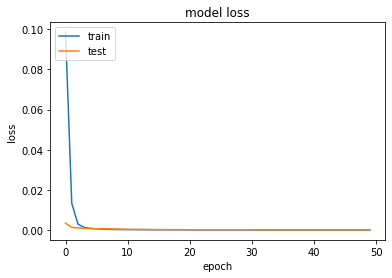

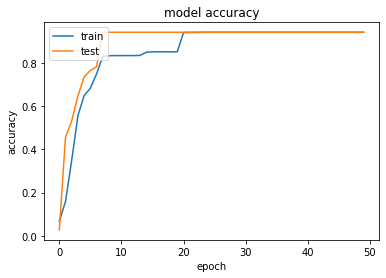

In [12]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=model.predict(x_test)
y_test_pred

array([[0.        , 0.06554516, 0.        , ..., 0.01927156, 0.01238301,
        0.        ],
       [0.        , 0.06554849, 0.        , ..., 0.01927139, 0.01237817,
        0.        ],
       [0.        , 0.06554811, 0.        , ..., 0.01927198, 0.01237819,
        0.        ],
       ...,
       [0.        , 0.06554803, 0.        , ..., 0.01927239, 0.01237794,
        0.        ],
       [0.        , 0.06554521, 0.        , ..., 0.01927139, 0.01238317,
        0.        ],
       [0.        , 0.06554838, 0.        , ..., 0.01927189, 0.01237781,
        0.        ]], dtype=float32)

In [15]:
y_test

array([[[0.00011559, 0.06553685, 0.00011085, ..., 0.0021448 ,
         0.0014142 , 0.00052142]],

       [[0.00011088, 0.06553695, 0.00012144, ..., 0.01090628,
         0.00639894, 0.00234271]],

       [[0.0001138 , 0.06553686, 0.00011756, ..., 0.02938369,
         0.01855402, 0.00761428]],

       ...,

       [[0.00011103, 0.06553663, 0.00011547, ..., 0.05674056,
         0.03595096, 0.01243099]],

       [[0.00011477, 0.06553688, 0.00010965, ..., 0.00815022,
         0.00468672, 0.00148292]],

       [[0.00010879, 0.06553657, 0.00012025, ..., 0.00375339,
         0.00246608, 0.00081172]]], dtype=float32)

In [16]:
y_test=y_test[:,0]

In [17]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_tanh_mse_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [18]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_tanh_mse_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed